<a href="https://colab.research.google.com/github/aryanmangal769/stress_prediction_from_HRV/blob/main/RR_from_ECG_visualisation_and_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install wfdb

     |████████████████████████████████| 137 kB 5.0 MB/s 


In [ ]:
import os
import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

# physionet data
import wfdb
from wfdb import processing

import numpy as np
import pandas as pd

In [ ]:
project_path = os.path.join(os.getcwd(), os.pardir)
data_path = os.path.join(project_path, '/content/drive/MyDrive/HRV/Github_Dataset/')
output_path = os.path.join(project_path, '/content/drive/MyDrive/HRV/Github_Dataset/output')


# sample frequency 
settings = {}
settings['fs'] = 1/0.0645

# Helper Functions

In [ ]:
def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity


def get_rr_corrected(df):
  # detect peaks
  peaks, similarity = detect_peaks(df.heartrate, threshold=0.3)

  # group peaks so we get a single peak per beat (hopefully)
  grouped_peaks = group_peaks(peaks)

  # RR-intervals are the differences between successive peaks
  rr = np.diff(grouped_peaks)

  rr_corrected = rr.copy()
  rr_corrected[np.abs(zscore(rr)) > 2] = np.median(rr)
  return rr_corrected

def plot_rr_corrected(rr_corrected,rr):

  plt.title("RR-intervals", fontsize=24)
  plt.xlabel("Time (ms)", fontsize=16)
  plt.ylabel("RR-interval (ms)", fontsize=16)

  plt.plot(rr, color="red", linewidth=1, label="RR-intervals")
  plt.plot(rr_corrected, color="green", linewidth=2, label="RR-intervals after correction")
  plt.legend(fontsize=20)

def timedomain(rr):

  results = {}
  
  hr = 60000/rr
  
  # mean RR-interval
  results['Mean RR (ms)'] = np.mean(rr)
  results['STD RR/SDNN (ms)'] = np.std(rr)
  results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
  results['Mean HR (beats/min)'] = np.mean(hr)
  results['STD HR (beats/min)'] = np.std(hr)
  results['Min HR (beats/min)'] = np.min(hr)
  results['Max HR (beats/min)'] = np.max(hr)
  results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
  results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
  results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
  print("Time domain metrics - automatically corrected RR-intervals:")
  for k, v in results.items():
      print("- %s: %.2f" % (k, v))
  return results

def frequency_domain(rr, fs=4):

  # sample rate for interpolation
  steps = 1 / fs

  # create interpolation function based on the rr-samples. 
  x = np.cumsum(rr) / 1000.0
  f = interp1d(x, rr, kind='cubic')

  # now we can sample from interpolation function
  xx = np.arange(1, np.max(x), steps)
  rr_interpolated = f(xx)
  # Estimate the spectral density using Welch's method
  fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)
  
  '''
  Segement found frequencies in the bands 
    - Very Low Frequency (VLF): 0-0.04Hz 
    - Low Frequency (LF): 0.04-0.15Hz 
    - High Frequency (HF): 0.15-0.4Hz
  '''
  cond_vlf = (fxx >= 0) & (fxx < 0.04)
  cond_lf = (fxx >= 0.04) & (fxx < 0.15)
  cond_hf = (fxx >= 0.15) & (fxx < 0.4)
  
  # calculate power in each band by integrating the spectral density 
  vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
  lf = trapz(pxx[cond_lf], fxx[cond_lf])
  hf = trapz(pxx[cond_hf], fxx[cond_hf])
  
  # sum these up to get total power
  total_power = vlf + lf + hf

  # find which frequency has the most power in each band
  peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
  peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
  peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

  # fraction of lf and hf
  lf_nu = 100 * lf / (lf + hf)
  hf_nu = 100 * hf / (lf + hf)
  
  results = {}
  results['Power VLF (ms2)'] = vlf
  results['Power LF (ms2)'] = lf
  results['Power HF (ms2)'] = hf   
  results['Power Total (ms2)'] = total_power

  results['LF/HF'] = (lf/hf)
  results['Peak VLF (Hz)'] = peak_vlf
  results['Peak LF (Hz)'] = peak_lf
  results['Peak HF (Hz)'] = peak_hf

  results['Fraction LF (nu)'] = lf_nu
  results['Fraction HF (nu)'] = hf_nu
  
  print("Frequency domain metrics:")
  for k, v in results.items():
      print("- %s: %.2f" % (k, v))
  return results, fxx, pxx


# Given Data


This is the data extraction and visualtion part for the ecg files of [this](https://github.com/stetelepta/exploring-heart-rate-variability/) repo.
This Section can be ignored if want to work on MIT BIH dataset

In [ ]:
df = pd.read_csv(os.path.join(data_path, "ecg.csv"), sep=";", index_col="ms")

In [ ]:
rr_corrected=get_rr_corrected(df)
timedomain(rr_corrected)

Time domain metrics - automatically corrected RR-intervals:
- Mean RR (ms): 866.54
- STD RR/SDNN (ms): 62.25
- Mean HR (Kubios' style) (beats/min): 69.24
- Mean HR (beats/min): 69.61
- STD HR (beats/min): 5.22
- Min HR (beats/min): 58.37
- Max HR (beats/min): 88.76
- RMSSD (ms): 60.51
- NNxx: 123.00
- pNNxx (%): 35.45


{'Max HR (beats/min)': 88.75739644970415,
 "Mean HR (Kubios' style) (beats/min)": 69.24051601145362,
 'Mean HR (beats/min)': 69.61302473694381,
 'Mean RR (ms)': 866.5446685878962,
 'Min HR (beats/min)': 58.36575875486381,
 'NNxx': 123,
 'RMSSD (ms)': 60.51345811236343,
 'STD HR (beats/min)': 5.21575600785895,
 'STD RR/SDNN (ms)': 62.246466923727546,
 'pNNxx (%)': 35.44668587896253}

Applying window

In [ ]:
df1=df.rolling(window=5000)
i=0
for df2 in df1:
  if i> 5000 and i<5002:
    print((df2))
    rr_corrected= get_rr_corrected(df2)
    plot_rr_corrected(rr_corrected)
    print(rr_corrected)
    results=timedomain(rr_corrected)
    results, fxx, pxx =frequency_domain(rr_corrected)
  i+=1
print(i)

In [ ]:
plot_rr_corrected(rr_corrected,rr)

In [ ]:
np.savetxt(os.path.join(output_path, "rr.txt"), rr_corrected, fmt='%d')

# On our data (MIT BIH DATASET)

Load DataSET

In [ ]:
df = pd.read_excel(os.path.join(data_path, "drive01.xlsx"))
df.ms=1000*df.ms                     #Convert senconds to MS

## For Initial Testing

Ploting data (Note: Chnage .index to .ms while plotting to get correct scaling)

In [ ]:
plt.figure(figsize=(40, 10))
start = 0
stop = 100
duration = (stop-start) *65/1000   ### Chnage thier sampling frequency to our sampling frequency
plt.title("ECG signal, slice of %.1f seconds" % duration, fontsize=24)
plt.plot(df[start:stop].ms, df[start:stop].heartrate, color="#51A6D8", linewidth=1)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)

### To plot Qrs complex Applied signal

In [ ]:
start=1100        ## Range to start and end Plot
stop = 1200
cond_slice = (df.index >= start) & (df.index < stop) 
ecg_signal = df.heartrate[cond_slice]
t = np.linspace(1.5 * np.pi, 3.5 * np.pi,5)
qrs_filter = -np.sin(t)
peaks,similarity=detect_peaks(ecg_signal,threshold=0.4,qrs_filter=qrs_filter)  ### Threshold Is changes and qrs filter is manually given
print(peaks)
plt.plot(similarity)

to get rr_corrected of manual signal

In [ ]:
grouped_peaks = group_peaks(peaks,threshold=1.5)   ### Chnaged from 5 to 1.5
print(grouped_peaks)
lst3 = [value for value in peaks if value not in grouped_peaks]
print(lst3)
final=[element * 65 for element in lst3]
print(final)
rr_corrected= np.diff(final)

## Final Code for our data

## MEthod 1

The code on the github repository [Link](https://github.com/stetelepta/exploring-heart-rate-variability/) had issues to work on MIT BIH dataset. SO the canges were made and 2 methods are introduced. More about these method can be read from [here](https://www.notion.so/Making-Stelepta-s-HRV-code-Work-on-our-data-542885cc1187445c8cbe4bbca94e84ed)

In [ ]:
def get_rr_corrected_ourdata(df):
  # detect peaks
  t = np.linspace(1.5 * np.pi, 3.5 * np.pi,13)
  qrs_filter = -np.sin(t)
  peaks, similarity = detect_peaks(df.heartrate, threshold=0.03,qrs_filter=qrs_filter)
 
  # group peaks so we get a single peak per beat (hopefully)
  grouped_peaks = group_peaks(peaks,threshold=3)
  # print(grouped_peaks)

  final=[element * 65 for element in grouped_peaks] 
  # print(final)
  # RR-intervals are the differences between successive peaks
  rr = np.diff(final)

  rr_corrected = rr.copy()
  rr_corrected[np.abs(zscore(rr)) > 2] = np.median(rr)
  return rr_corrected

In [ ]:
rr_corrected=get_rr_corrected_ourdata(df)
results=timedomain(rr_corrected)
x,y,z=frequency_domain(rr_corrected)

Time domain metrics - automatically corrected RR-intervals:
- Mean RR (ms): 675.58
- STD RR/SDNN (ms): 83.45
- Mean HR (Kubios' style) (beats/min): 88.81
- Mean HR (beats/min): 90.09
- STD HR (beats/min): 10.62
- Min HR (beats/min): 54.30
- Max HR (beats/min): 167.83
- RMSSD (ms): 107.60
- NNxx: 3078.00
- pNNxx (%): 54.35
Frequency domain metrics:
- Power VLF (ms2): 424.39
- Power LF (ms2): 1256.54
- Power HF (ms2): 2144.68
- Power Total (ms2): 3825.61
- LF/HF: 0.59
- Peak VLF (Hz): 0.02
- Peak LF (Hz): 0.08
- Peak HF (Hz): 0.25
- Fraction LF (nu): 36.94
- Fraction HF (nu): 63.06


In [ ]:
len(rr_corrected)

5663

## On Github drive01.rr file

In [ ]:
filename= (os.path.join(data_path, "drive01.rr"))

In [ ]:
rr_given=[]
with open(filename) as fh:
  for line in fh:
    # print(line.strip().split(" ")[1])
    rr_given.append(float(line.strip().split(" ")[1]))
rr_given=np.array(rr_given)
len(rr_given)

5716

In [ ]:
rr_given= np.multiply(rr_given,1000)

In [ ]:
timedomain(rr_given)
results=timedomain(rr_given)
x,y,z=frequency_domain(rr_given)

Time domain metrics - automatically corrected RR-intervals:
- Mean RR (ms): 0.69
- STD RR/SDNN (ms): 0.17
- Mean HR (Kubios' style) (beats/min): 86447.27
- Mean HR (beats/min): 90118.41
- STD HR (beats/min): 18077.45
- Min HR (beats/min): 20215.63
- Max HR (beats/min): 309278.35
- RMSSD (ms): 0.23
- NNxx: 0.00
- pNNxx (%): 0.00


{'Max HR (beats/min)': 309278.3505154639,
 "Mean HR (Kubios' style) (beats/min)": 86447.26832580761,
 'Mean HR (beats/min)': 90118.40608600549,
 'Mean RR (ms)': 0.6940647305808256,
 'Min HR (beats/min)': 20215.633423180592,
 'NNxx': 0,
 'RMSSD (ms)': 0.22649519220281172,
 'STD HR (beats/min)': 18077.445162445863,
 'STD RR/SDNN (ms)': 0.1693586190783866,
 'pNNxx (%)': 0.0}

## Method 2

In [ ]:
def group_peaks_new(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)
    peak_groups2=np.empty(0)
    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        peak_groups2 = np.append(peak_groups2,np.where(peak_groups == i))
        output = np.append(output, np.median(peak_group))

    p=np.delete(p,peak_groups2.astype(int))

    output=np.concatenate([p,output])
    return np.sort(output)

In [ ]:
def get_rr_corrected_ourdata_old(df):
  # detect peaks
  t = np.linspace(1.5 * np.pi, 3.5 * np.pi,5)
  qrs_filter = -np.sin(t)
  peaks, similarity = detect_peaks(df.heartrate, threshold=0.05,qrs_filter=qrs_filter)
 
  # group peaks so we get a single peak per beat (hopefully)
  grouped_peaks = group_peaks_new(peaks,threshold=3)
  
  final=[element * 65 for element in grouped_peaks] 
  # print(final)
  # RR-intervals are the differences between successive peaks
  rr = np.diff(final)
  # print(rr)
  rr_corrected = rr.copy()
  rr_corrected[np.abs(zscore(rr)) > 2] = np.median(rr)
  return rr_corrected

In [ ]:
x=get_rr_corrected_ourdata_old(df)
print(len(x))

6784


## To get a proper visualisation of peaks corresponing to each r peak (Can be used to tune params and compare both methonds)

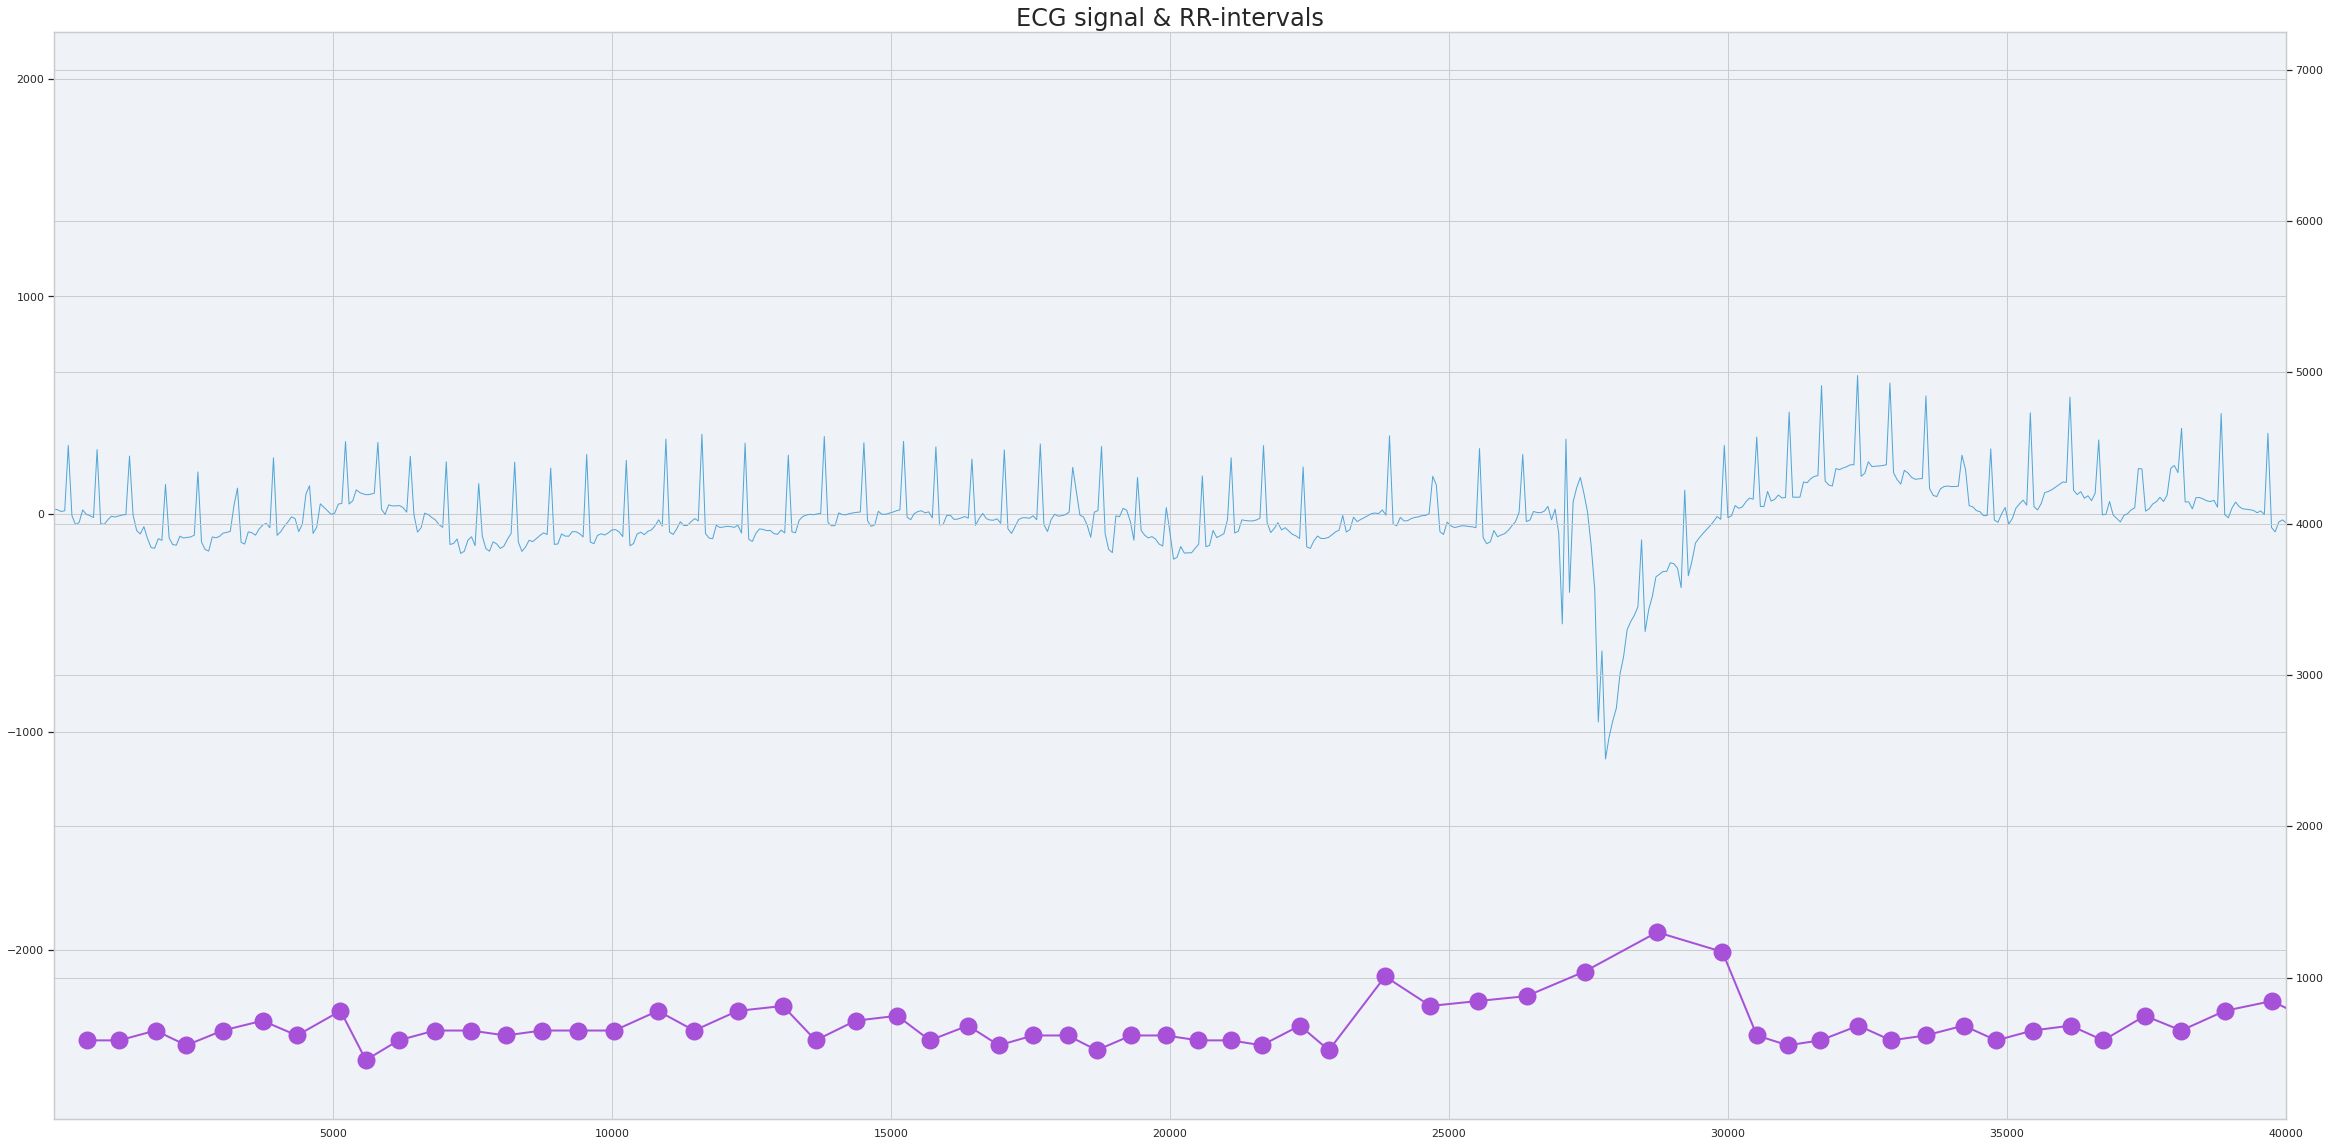

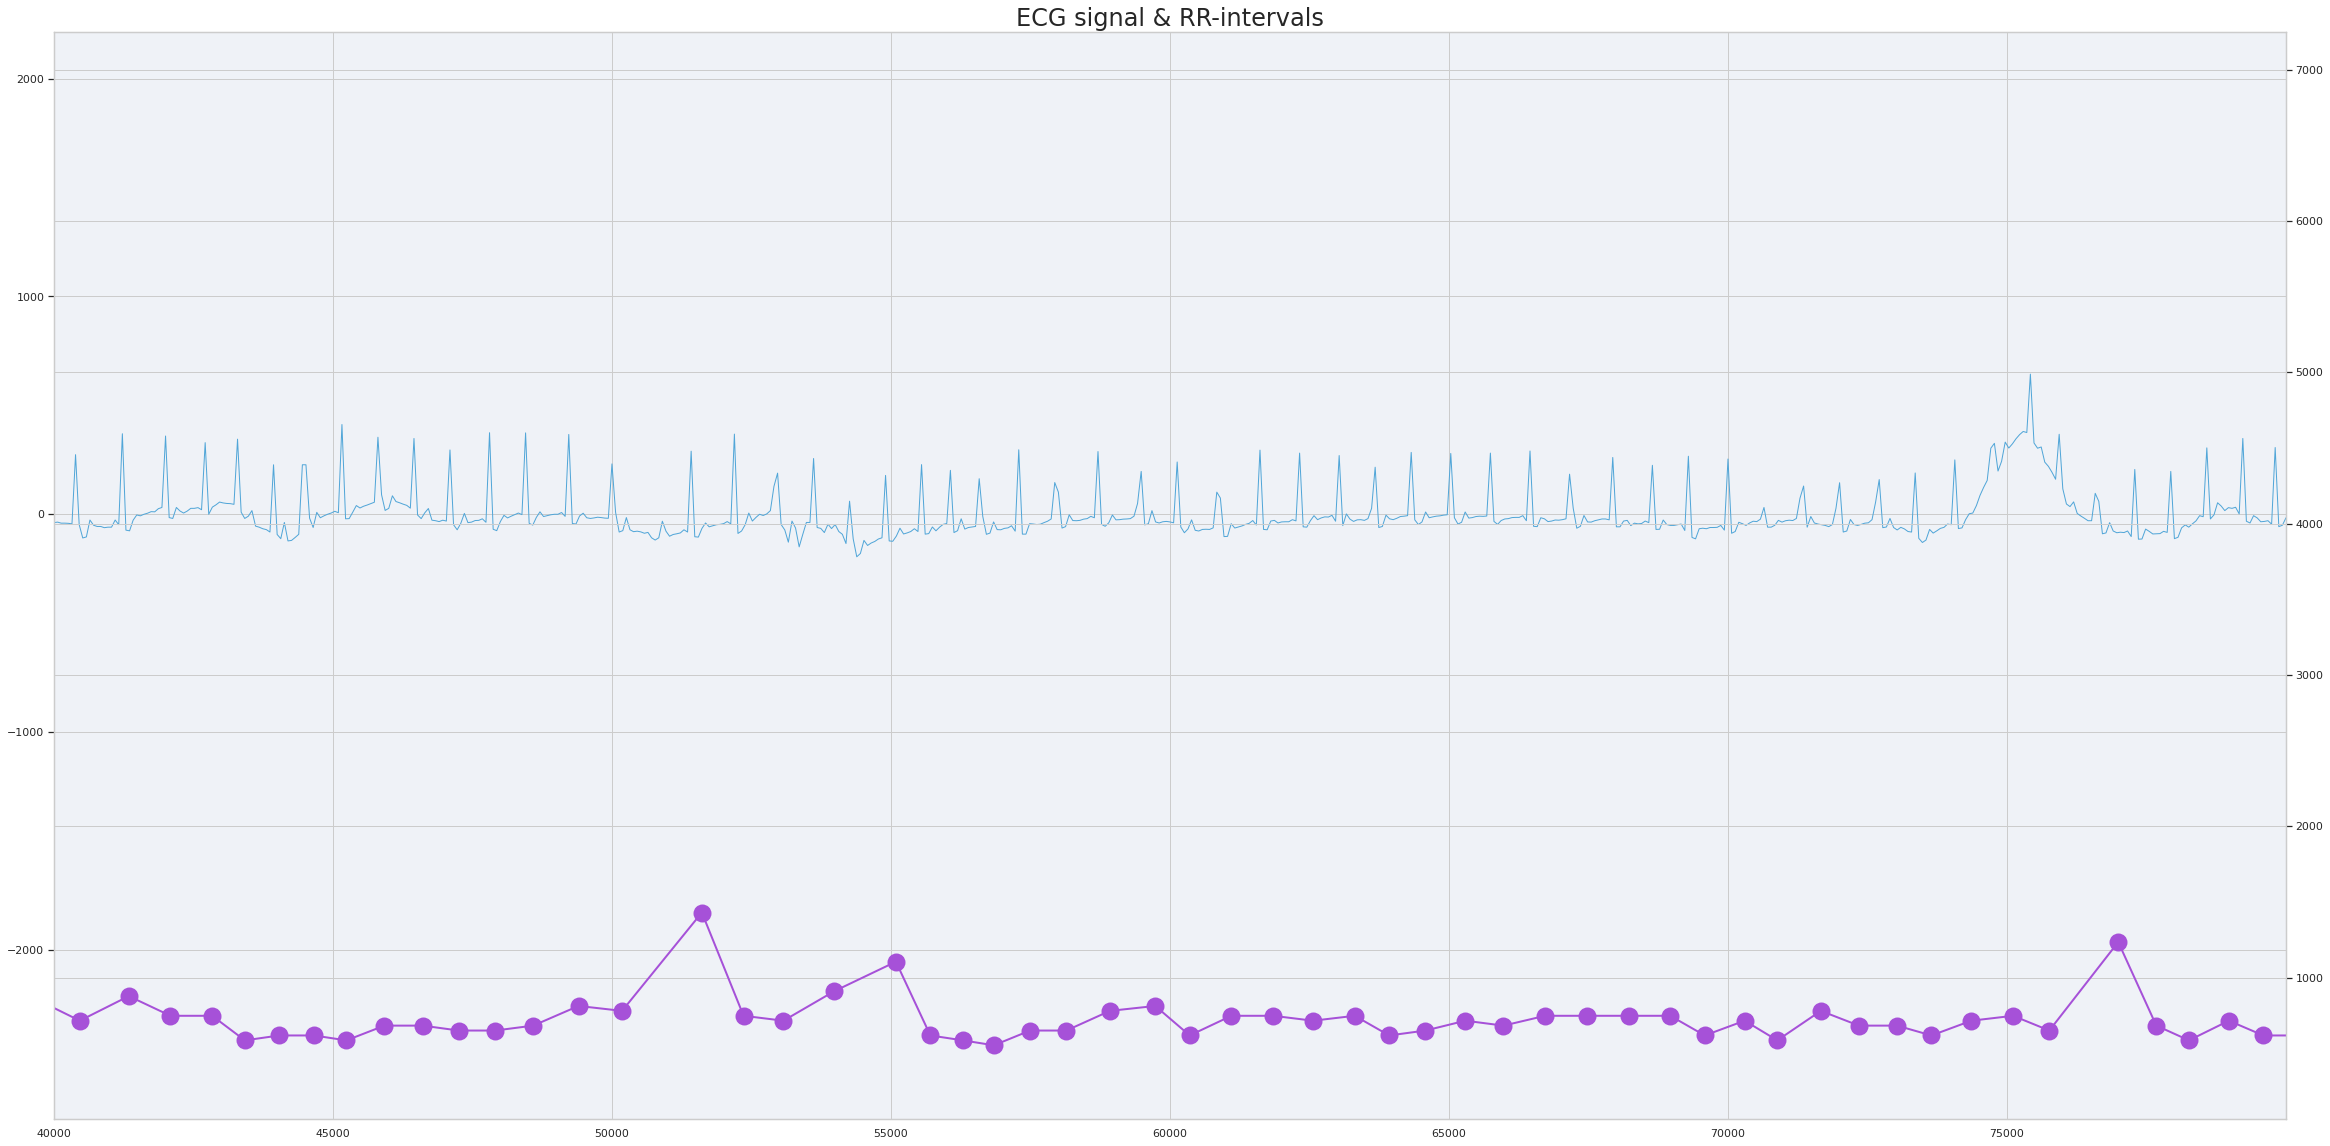

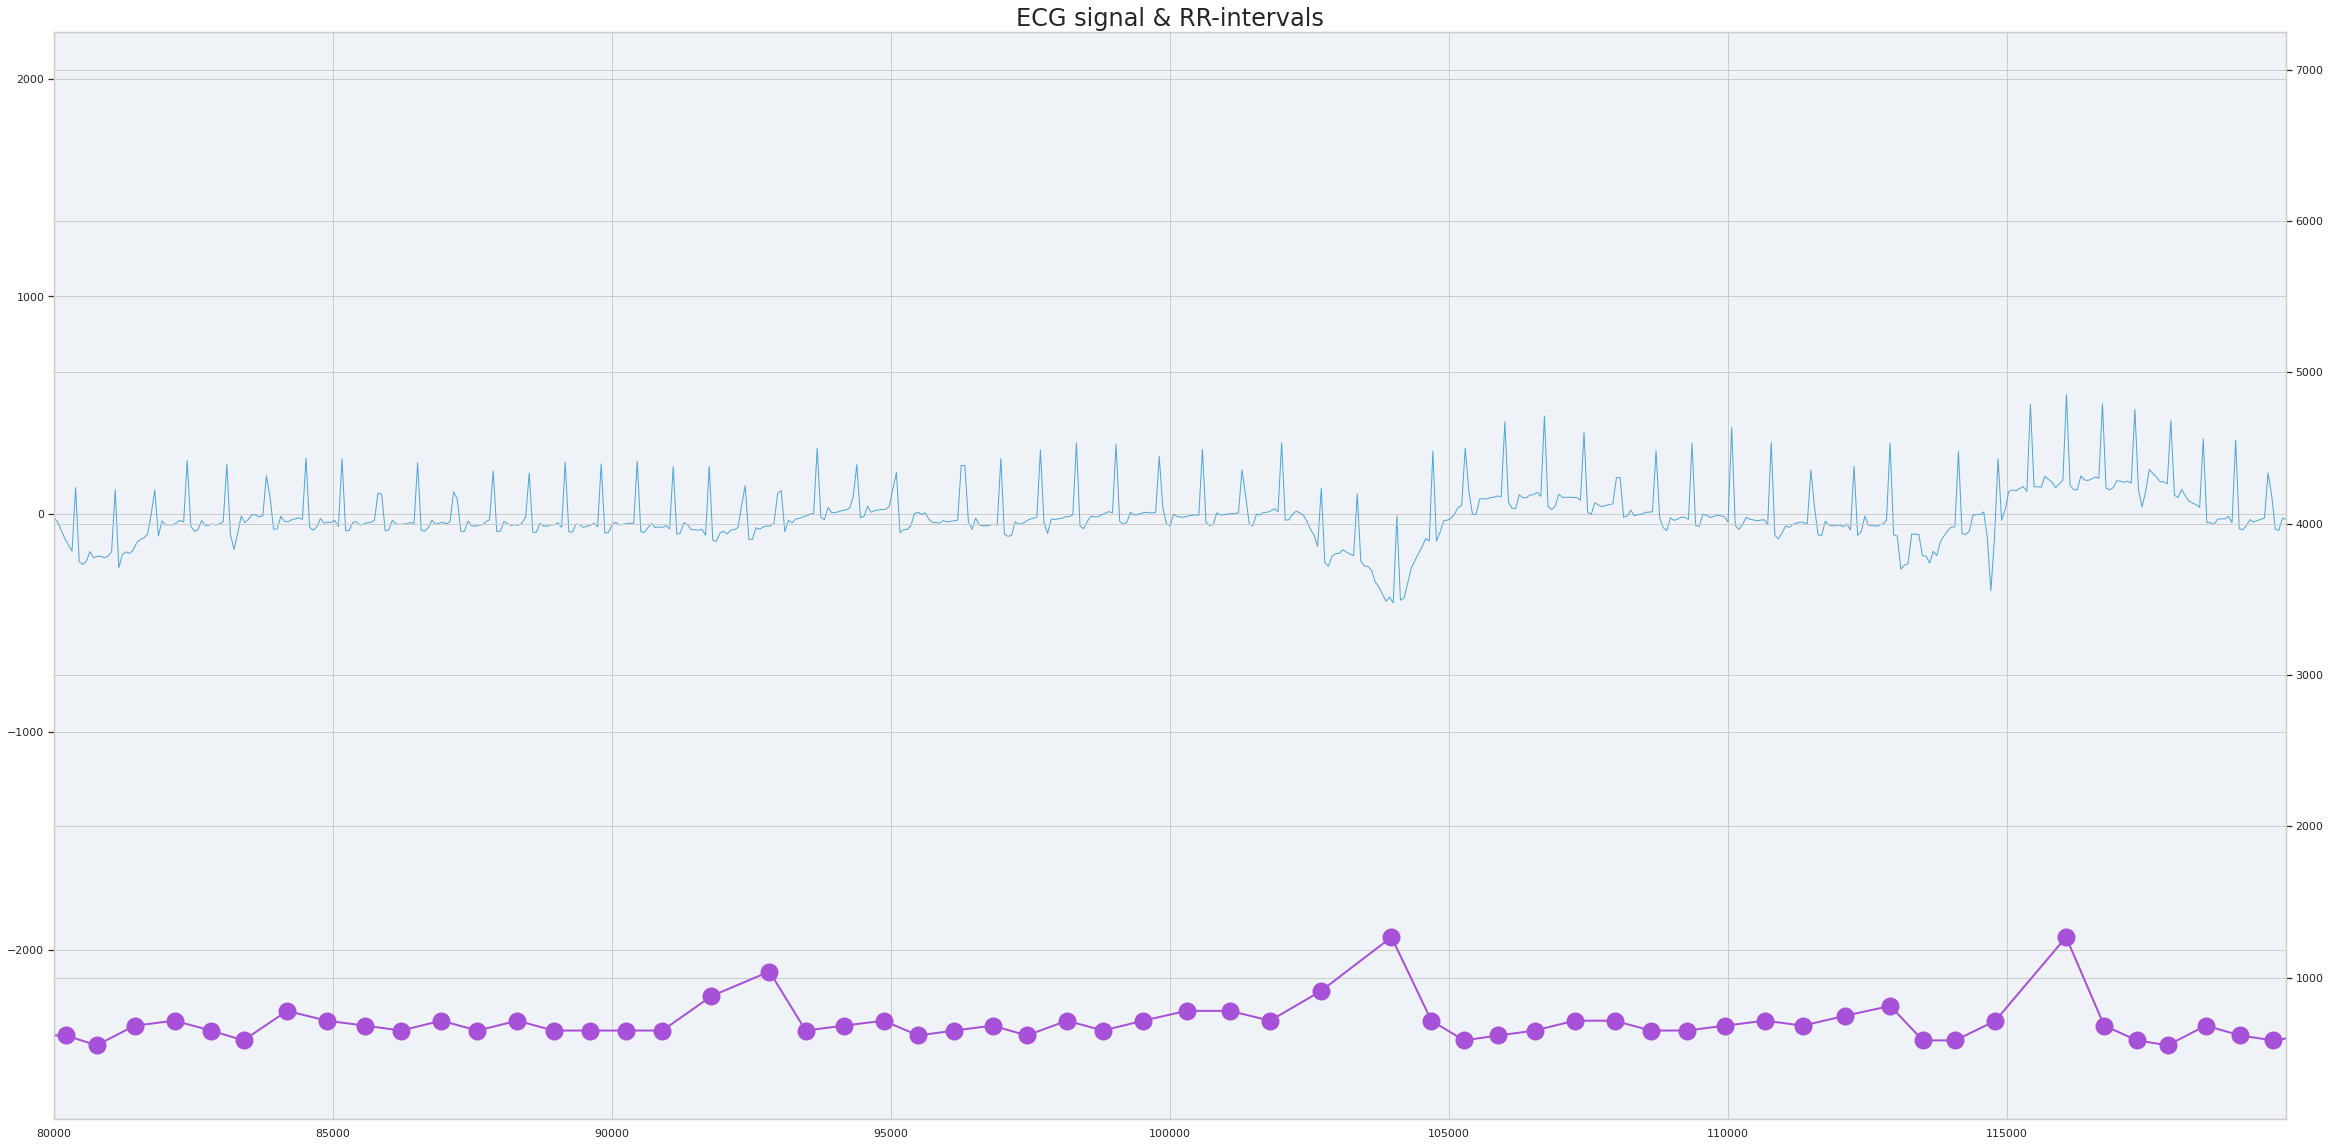

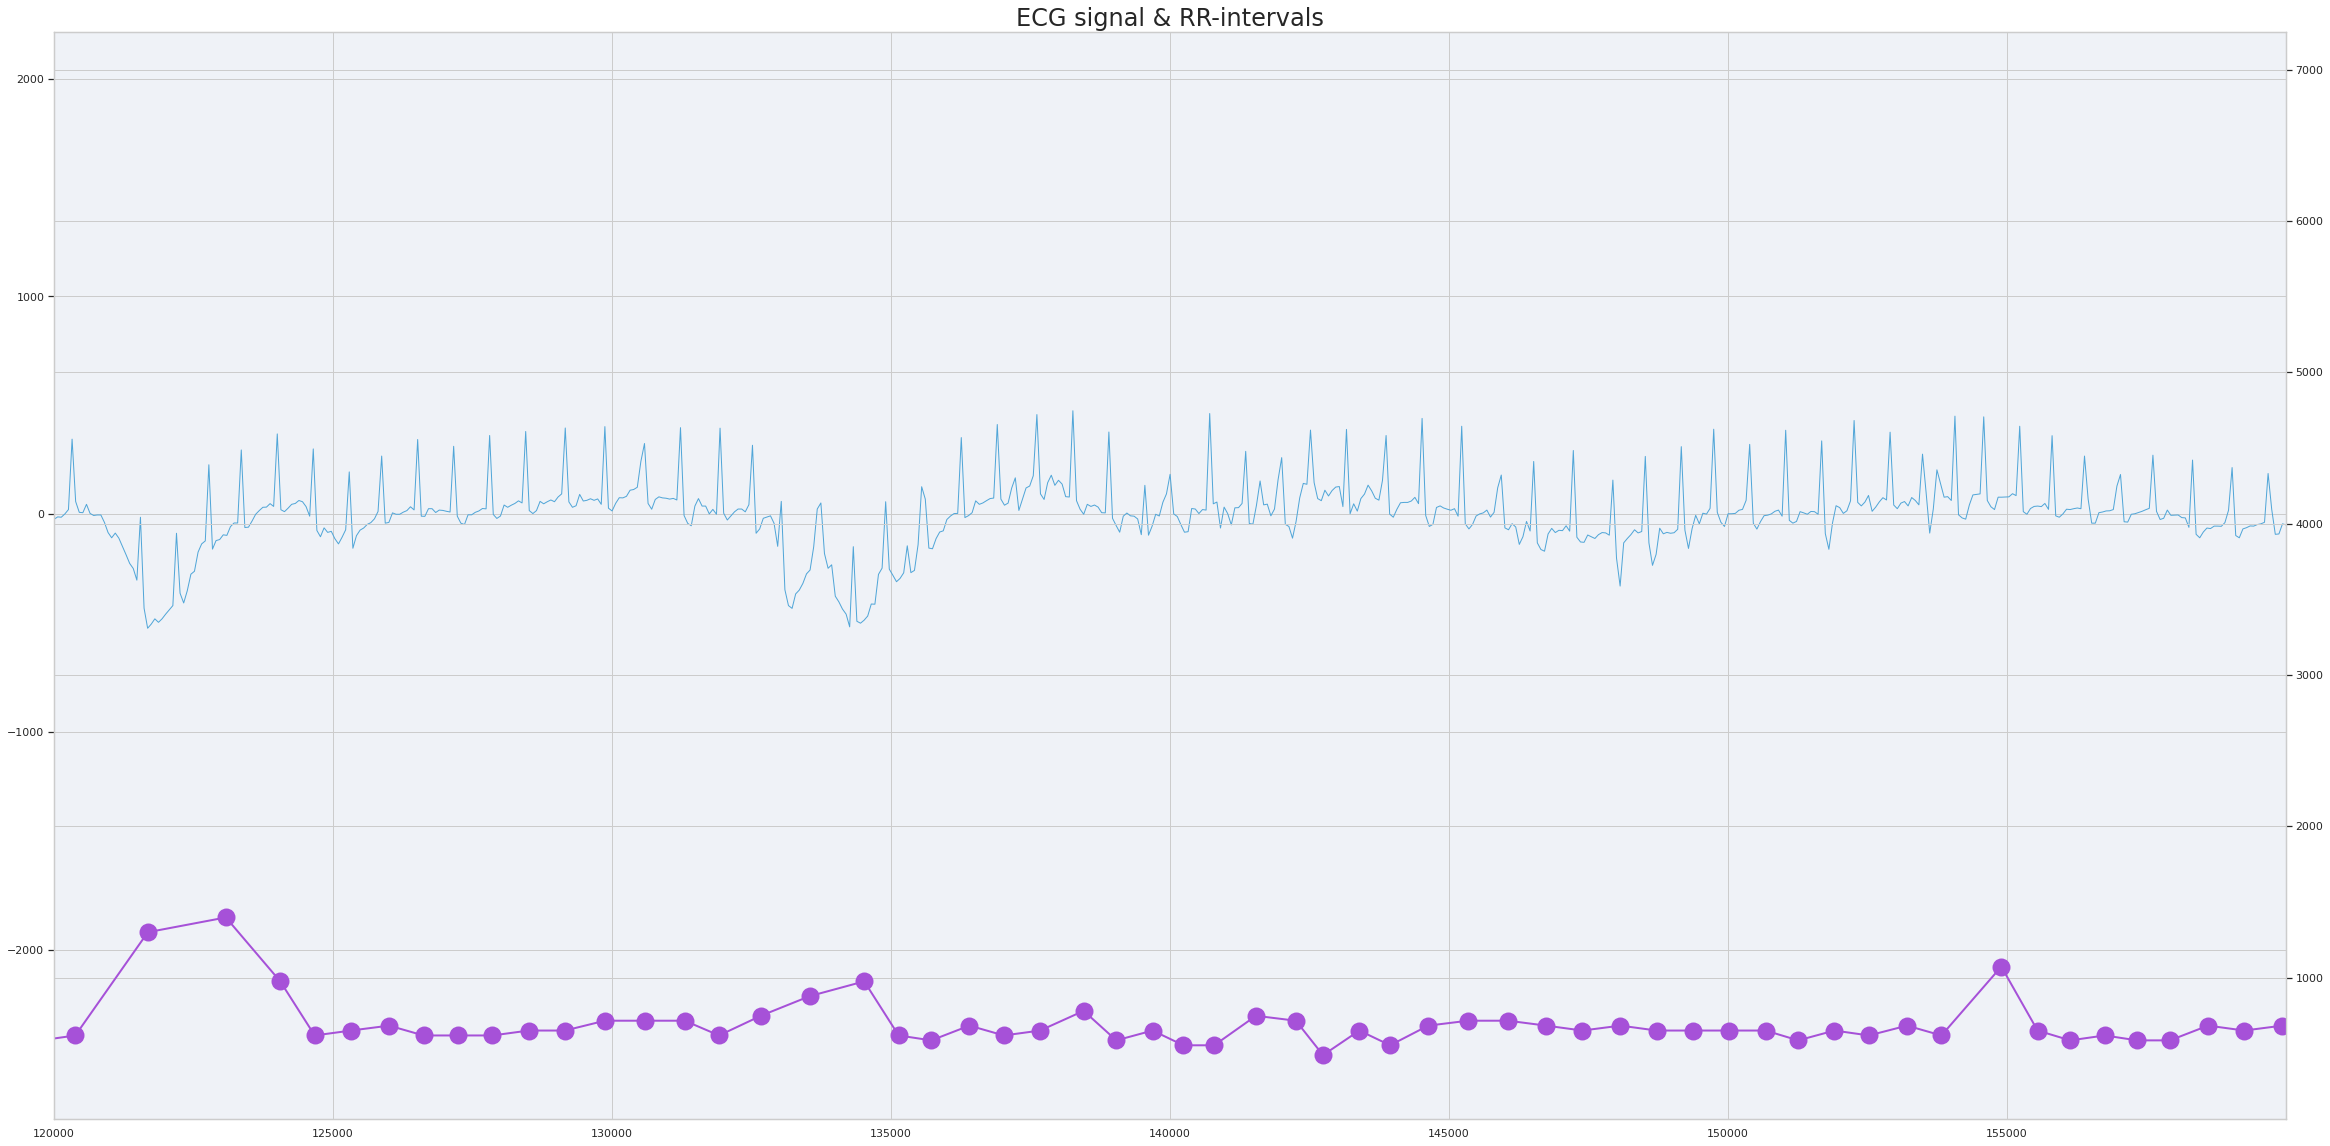

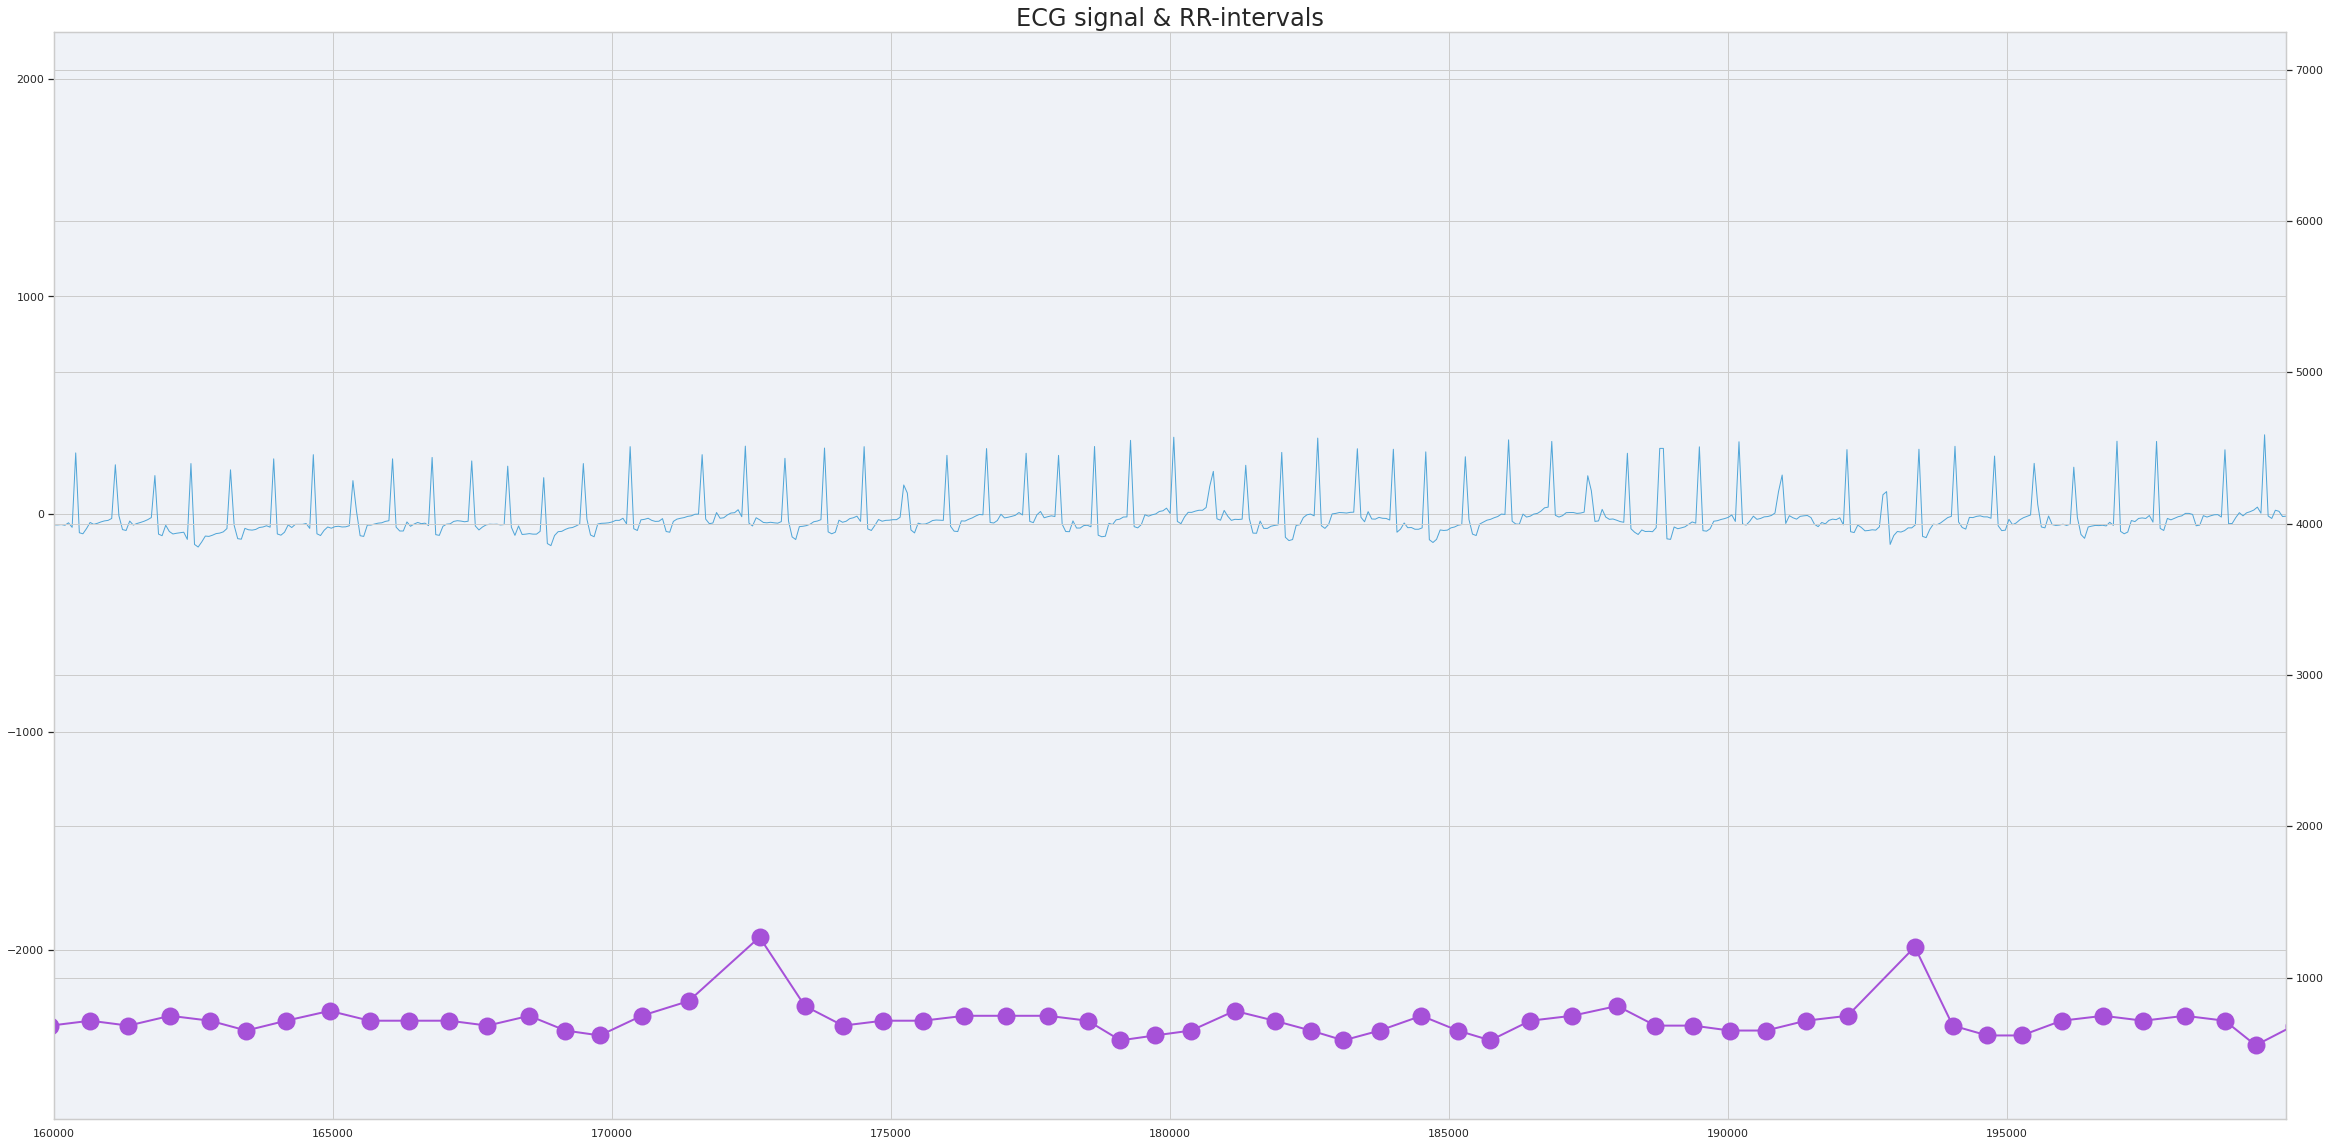

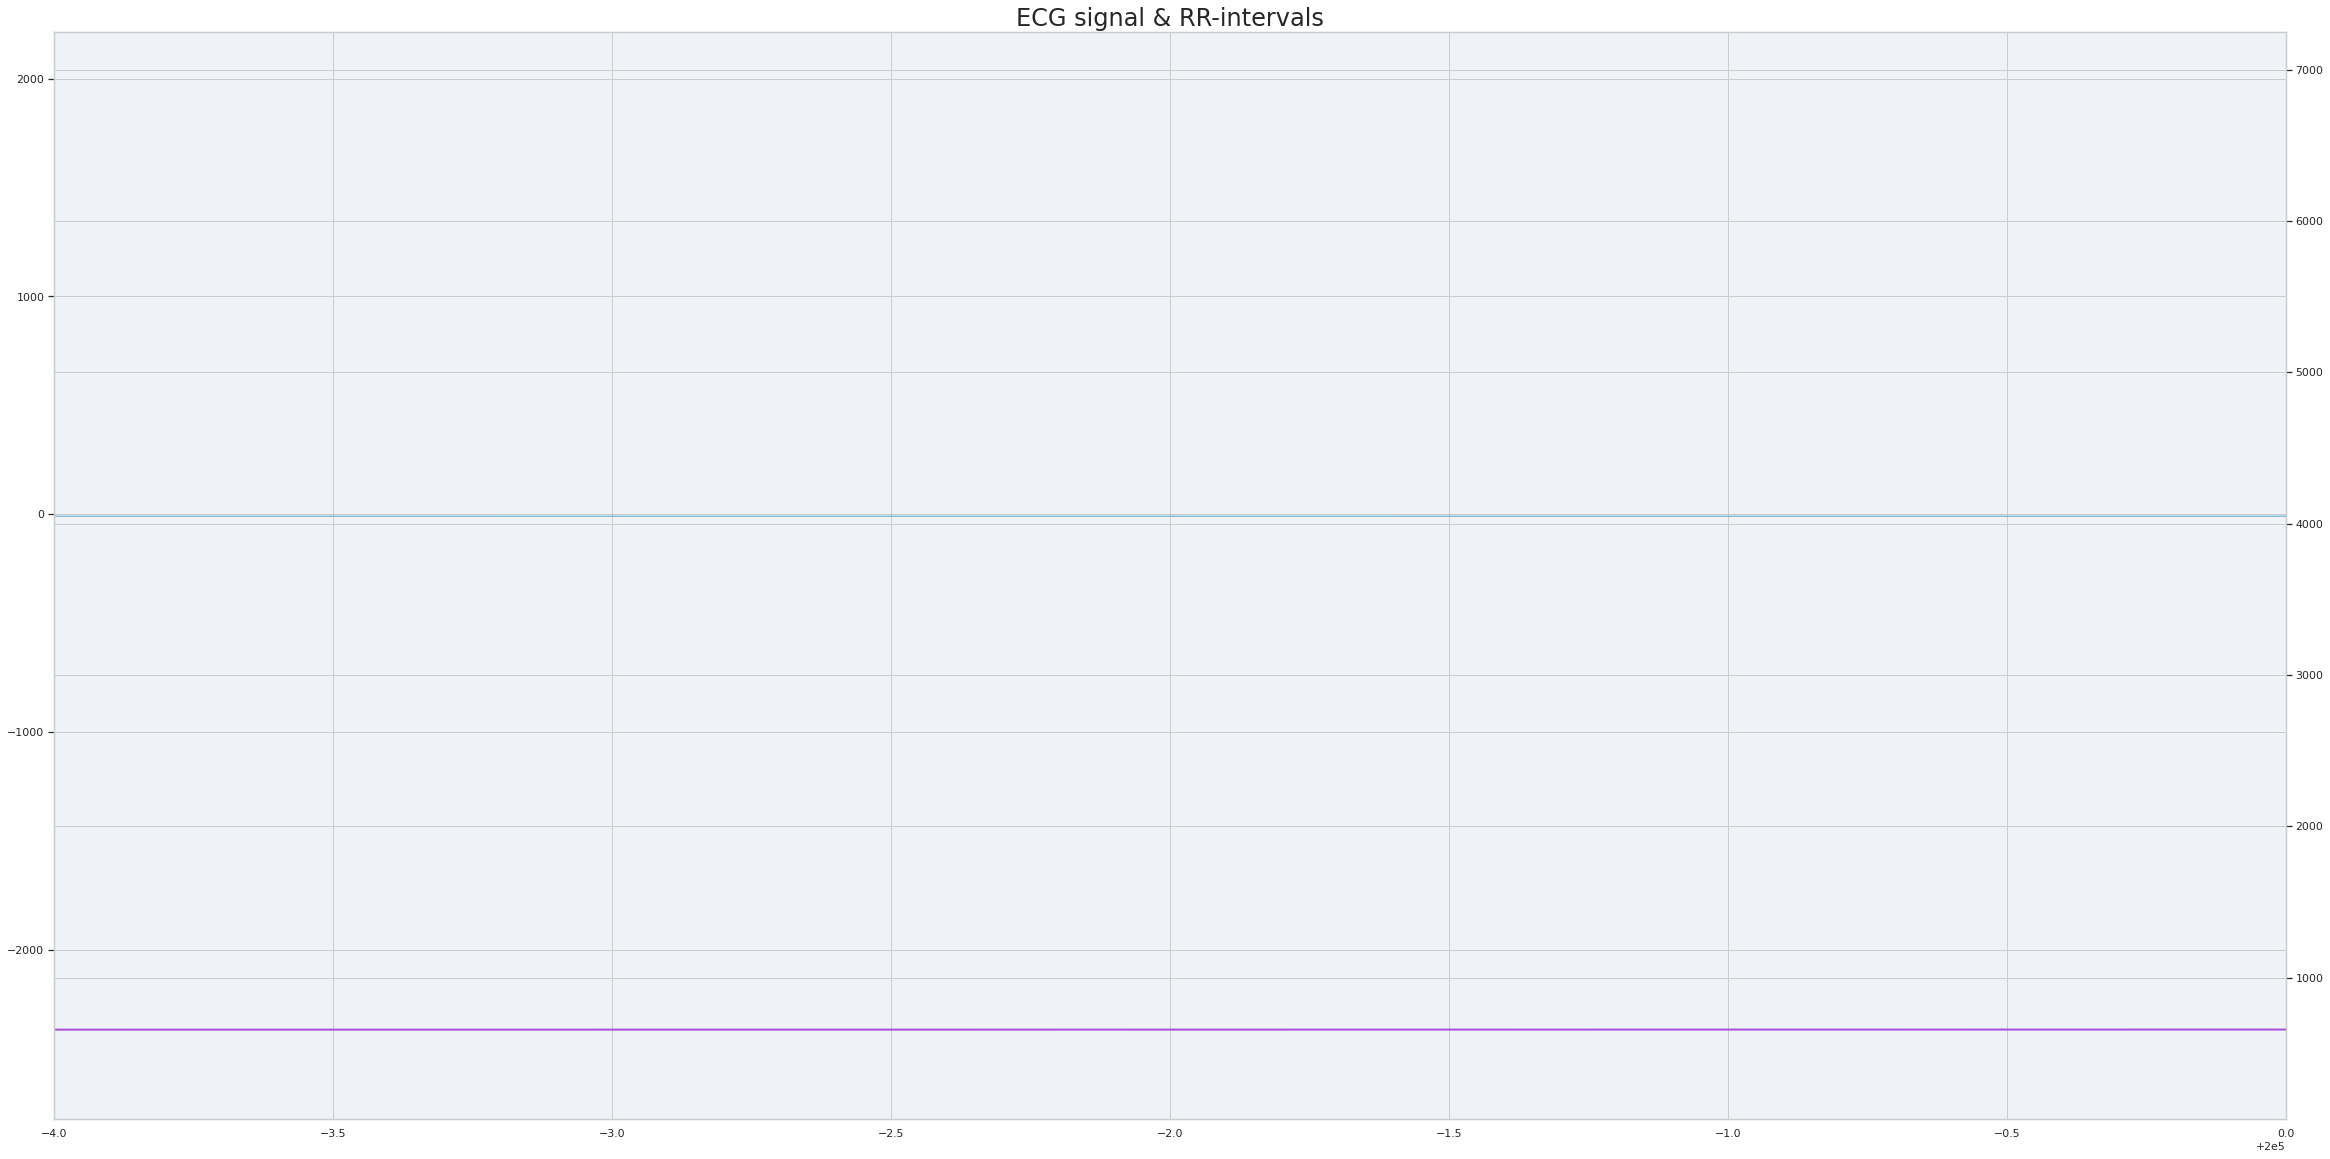

In [ ]:
sampfrom =1
sampto = 200000
nr_plots = 5

t = np.linspace(1.5 * np.pi, 3.5 * np.pi,13)
qrs_filter = -np.sin(t)
peaks, similarity = detect_peaks(df.heartrate, threshold=0.03,qrs_filter=qrs_filter)
# plt.plot(similarity[1000:1100])
# group peaks so we get a single peak per beat (hopefully)
grouped_peaks = group_peaks(peaks,threshold=5)
# print(grouped_peaks)
# lst3 = [value for value in peaks if value not in grouped_peaks]
# print(lst3)
final=[element * 65 for element in grouped_peaks] 
rr = np.diff(final)
final=np.array(final)
for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    # plot similarity
    plt.figure(figsize=(40, 20))

    plt.title("ECG signal & RR-intervals", fontsize=24)
    plt.plot(df.ms, -800*df.heartrate, label="ECG", color="#51A6D8", linewidth=1)
    # plt.plot(final, np.repeat(600, final.shape[0]), markersize=14, label="Found peaks", color="orange", marker="o", linestyle="None")
    # plt.legend(loc="upper left", fontsize=20)
    # plt.xlabel("Time (milliseconds)", fontsize=16)
    # plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)
    # plt.gca().set_ylim(400, 800)
    
    ax2 = plt.gca().twinx()
    ax2.plot(np.cumsum(rr)+peaks[0], rr, label="RR-intervals", color="#A651D8", linewidth=2, markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=18)
    ax2.set_xlim(start, stop)
    # ax2.set_ylim(-2000, 2000)
    # ax2.legend(loc="upper right", fontsize=20)

    # plt.xlabel("Time (ms)", fontsize=16)
    # plt.ylabel("RR-interval (ms)", fontsize=16)

    # plt.savefig(os.path.join(output_path, "ecg-with-rr-%s-%s.png" % (start, stop)))